<a id='top'></a>

# ÍNDEX
*****

<ul>1. <a href='#importlibraries'>Librerías utilizadas</a></ul>
<ul>2. <a href='#loaddata'>Carga de datos</a></ul>
<ul><ul>2.1. <a href='#dataframe'>Carga de Dataframe</a></ul></ul>
<ul><ul>2.2. <a href='#loadimages'>Carga de Imágenes</a></ul></ul>
<ul>3. <a href='#dataexplo'>Exploración analítica de datos</a></ul>
<ul><ul>3.1. <a href='#histograms'>Histogramas</a></ul></ul>
<ul><ul>3.2. <a href='#plotsvstarget'>Representación visual de variables frente al 'Target'</a></ul></ul>
<ul><ul>3.3. <a href='#correlationmatrix'>Matriz de correlaciones</a></ul></ul>
<ul><ul>3.4. <a href='#categoricalvariables'>Variables categóricas</a></ul></ul>
<ul>4. <a href='#dataprep'>Preparación de datos</a></ul>
<ul><ul>4.1. <a href='#fillna'> Imputación de valores no disponibles</a></ul></ul>
<ul><ul>4.2. <a href='#dummies'>Variables dummy</a></ul></ul>
<ul><ul>4.3. <a href='#dropvariables'>Eliminación de atributos sin relevancia</a></ul></ul>
<ul>5. <a href='#featureselection'>Selección de variables</a></ul>
<ul>6. <a href='#model'>Selección y entrenamiento del modelo</a></ul>
<ul><ul>6.1. <a href='#evaluation'>Evaluación del modelo</a></ul></ul>

* <a href='#functions'>Apéndice 1: Funciones</a>


<a id='importlibraries'></a> 

### 1. Librerias utilizadas  <p style="text-align: right;"> <a href='#top'>Return to top</a> </p>


In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import glob
import copy
import scipy.misc as scpm
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

%matplotlib inline

<a id='loaddata'></a> 
### 2. Carga de datos  <p style="text-align: right;"> <a href='#top'>Return to top</a> </p>

<a id='dataframe'></a> 
#### 2.1. Carga de Dataframe <p style="text-align: right;">

In [11]:
modelar= pd.read_csv('data/Modelar_UH2019.txt', sep="|")
estimar = pd.read_csv('data/Estimar_UH2019.txt', sep="|")

print('Modelar:', modelar.shape, 'Estimar:', estimar.shape)

Modelar: (9958, 53) Estimar: (1104, 52)


In [12]:
modelar.head(3)

,HY_id,HY_cod_postal,HY_provincia,HY_descripcion,HY_distribucion,HY_tipo,HY_antiguedad,HY_metros_utiles,HY_metros_totales,HY_num_banos,...,IDEA_unitprice_rent_residential,IDEA_price_rent_residential,IDEA_stock_rent_residential,IDEA_demand_rent_residential,GA_page_views,GA_mean_bounce,GA_exit_rate,GA_quincena_ini,GA_quincena_ult,TARGET
0,6028499,18151,Granada,Plaza de Garaje ubicada en la planta sótano de...,NaN,Garaje,NaN,NaN,35.00,0,...,5.09,626.38,237.0,51.01,71,7.14,10.65,2,46,32.16
1,6028500,29915,Málaga,NaN,NaN,Casa de pueblo,NaN,NaN,151.98,2,...,4.08,700.00,6.0,50.69,684,16.36,5.25,1,47,30.71
2,6028502,3740,Alicante,El inmueble(piso) se encuentra situado en el d...,VIVIENDA-PISO,Piso,2008.0,92.58,102.78,1,...,4.43,525.00,15.0,51.82,651,15.12,11.21,1,47,63.48


<a id='loadimages'></a> 

#### 2.2. Carga de Imágenes <p style="text-align: right;"> <a href='#top'>Return to top</a> </p>


In [13]:
#Función para cargar todas las imágenes en la carpeta:
def load_images(filenames):
    images = np.asarray([scpm.imread(file) for file in filenames])
    return images

#Se obtienen los nombres de los archivos en la carpeta:
names = sorted(glob.glob('imagenes_inmuebles_haya/*.jpg'))
print('Número total de imágenes cargadas:', len(names))

lista=[names[i][24:31] for i in range(len(names))]

#Cantidad de imágenes por HY_id
num_images=pd.DataFrame(Counter(lista), index=['num_images']).transpose()
num_images=num_images.reset_index()
num_images['HY_id']=num_images['index'].astype(int)
num_images.drop(['index'], axis=1,inplace=True)
num_images.head()

Número total de imágenes cargadas: 47381


,num_images,HY_id
0,5,6028499
1,3,6028500
2,10,6028502
3,2,6028512
4,2,6028513


Se incorpora una nueva variable *num_images*, que cuenta la cantidad de imágenes disponibles por anuncio, al dataframe:

In [14]:
modelar=pd.merge(modelar, num_images, how='left', on = 'HY_id')

In [15]:
modelar_p=modelar[['HY_id']]
modelar_p.insert(1, 'piscina', False)
modelar_p['piscina']=modelar.loc[modelar['HY_descripcion'].notnull()]['HY_descripcion'].str.contains('iscina')
modelar_p.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,HY_id,piscina
0,6028499,False
1,6028500,NaN
2,6028502,False
3,6028512,False
4,6028513,False


Se incorpora una nueva variable denominada piscina que indica la existencia o no de la piscina en la descripciónd del anuncio.

In [16]:
modelar.shape

(9958, 54)

In [17]:
modelar=pd.merge(modelar, modelar_p, how='left', on = 'HY_id')

In [18]:
modelar['has_image'] = modelar['num_images'].notnull().astype(int)

#### Nota: 
La imagen *'6031545__posifoto3__1K9lJvlehV.jpg'* ha sido eliminada al estar corrupta y no poder visualizarse:

        import os 
        os.remove("imagenes_inmuebles_haya\\6031545__posifoto3__1K9lJvlehV.jpg")


In [19]:
modelar.head(5).transpose()

,0,1,2,3,4
HY_id,6028499,6028500,6028502,6028512,6028513
HY_cod_postal,18151,29915,3740,30592,30592
HY_provincia,Granada,Málaga,Alicante,Murcia,Murcia
HY_descripcion,Plaza de Garaje ubicada en la planta sótano de...,NaN,El inmueble(piso) se encuentra situado en el d...,Plaza de garaje situada en la planta semisótan...,Plaza de garaje situada en la planta semisótan...
HY_distribucion,NaN,NaN,VIVIENDA-PISO,NaN,NaN
HY_tipo,Garaje,Casa de pueblo,Piso,Garaje,Garaje
HY_antiguedad,NaN,NaN,2008,NaN,NaN
HY_metros_utiles,NaN,NaN,92.58,11.81,14.29
HY_metros_totales,35,151.98,102.78,12.46,15.43
HY_num_banos,0,2,1,0,0


<a id='dataexplo'></a> 

### 3. Exploración analítica de datos <p style="text-align: right;"> <a href='#top'>Return to top</a> </p>



Se añade una variable *Descr_len* que mide la longitud de la descripción de la vivienda en el anuncio:

In [10]:
modelar['descr_len']= modelar['HY_descripcion'].str.len()
modelar.head(3)

,HY_id,HY_cod_postal,HY_provincia,HY_descripcion,HY_distribucion,HY_tipo,HY_antiguedad,HY_metros_utiles,HY_metros_totales,HY_num_banos,...,GA_page_views,GA_mean_bounce,GA_exit_rate,GA_quincena_ini,GA_quincena_ult,TARGET,num_images,piscina,has_image,descr_len
0,6028499,18151,Granada,Plaza de Garaje ubicada en la planta sótano de...,NaN,Garaje,NaN,NaN,35.00,0,...,71,7.14,10.65,2,46,32.16,5.0,False,1,397.0
1,6028500,29915,Málaga,NaN,NaN,Casa de pueblo,NaN,NaN,151.98,2,...,684,16.36,5.25,1,47,30.71,3.0,NaN,1,NaN
2,6028502,3740,Alicante,El inmueble(piso) se encuentra situado en el d...,VIVIENDA-PISO,Piso,2008.0,92.58,102.78,1,...,651,15.12,11.21,1,47,63.48,10.0,False,1,226.0


In [11]:
modelar['has_description'] = modelar['descr_len'].notnull().astype(int)
modelar.head(4)

,HY_id,HY_cod_postal,HY_provincia,HY_descripcion,HY_distribucion,HY_tipo,HY_antiguedad,HY_metros_utiles,HY_metros_totales,HY_num_banos,...,GA_mean_bounce,GA_exit_rate,GA_quincena_ini,GA_quincena_ult,TARGET,num_images,piscina,has_image,descr_len,has_description
0,6028499,18151,Granada,Plaza de Garaje ubicada en la planta sótano de...,NaN,Garaje,NaN,NaN,35.00,0,...,7.14,10.65,2,46,32.16,5.0,False,1,397.0,1
1,6028500,29915,Málaga,NaN,NaN,Casa de pueblo,NaN,NaN,151.98,2,...,16.36,5.25,1,47,30.71,3.0,NaN,1,NaN,0
2,6028502,3740,Alicante,El inmueble(piso) se encuentra situado en el d...,VIVIENDA-PISO,Piso,2008.0,92.58,102.78,1,...,15.12,11.21,1,47,63.48,10.0,False,1,226.0,1
3,6028512,30592,Murcia,Plaza de garaje situada en la planta semisótan...,NaN,Garaje,NaN,11.81,12.46,0,...,15.82,14.55,2,47,108.27,2.0,False,1,149.0,1


En primer lugar se encuentran los valores no disponibles (*Missing Values*) para cada una de las variables:

In [12]:
modelar.shape

(9958, 58)

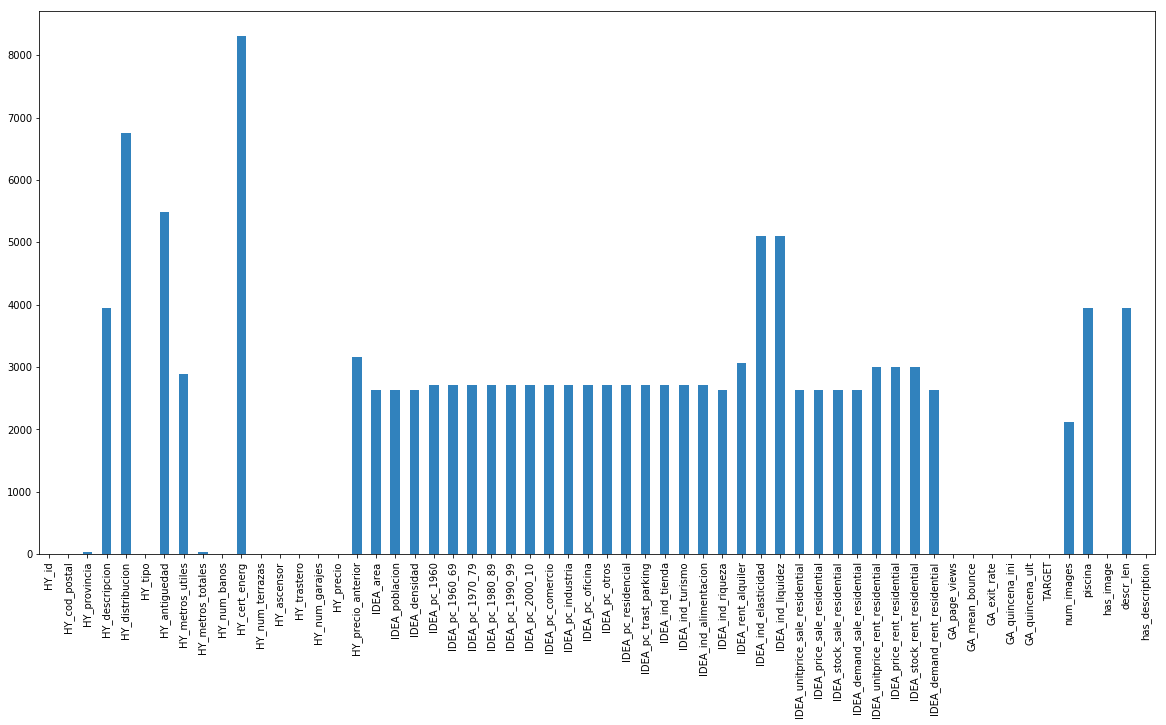

HY_id                                 0
HY_cod_postal                         0
HY_provincia                         42
HY_descripcion                     3942
HY_distribucion                    6745
HY_tipo                               0
HY_antiguedad                      5484
HY_metros_utiles                   2886
HY_metros_totales                    34
HY_num_banos                          0
HY_cert_energ                      8300
HY_num_terrazas                       0
HY_ascensor                           0
HY_trastero                           0
HY_num_garajes                        0
HY_precio                             0
HY_precio_anterior                 3158
IDEA_area                          2631
IDEA_poblacion                     2635
IDEA_densidad                      2635
IDEA_pc_1960                       2710
IDEA_pc_1960_69                    2710
IDEA_pc_1970_79                    2710
IDEA_pc_1980_89                    2710
IDEA_pc_1990_99                    2710


In [13]:
missing_val_count=modelar.isnull().sum()
missing_val_count.plot(kind='bar',figsize=(20,10),colormap='tab20c')
plt.show()
print(missing_val_count,'    ...')

Se observa la provincia de origen de las publicaciones de anuncios en idealista, con el objetivo de estudiar su efecto en la variable objetivo:

In [14]:
modelar['HY_provincia'].value_counts()

Valencia       2080
Almería        1768
Murcia         1516
Castellón      1347
Alicante        794
Málaga          534
Granada         384
Valladolid      300
Tarragona       293
Barcelona       161
Las Palmas      122
Madrid           77
Cádiz            74
Baleares         73
Albacete         45
La Rioja         45
Gerona           38
Soria            34
Córdoba          32
Teruel           22
Cuenca           21
Palencia         19
Guadalajara      19
León             18
Toledo           17
A Coruña         16
Sevilla          11
Huelva           10
Avila             9
Zaragoza          9
Lérida            5
Ciudad Real       5
Pontevedra        5
Huesca            3
Tenerife          2
Burgos            2
Badajoz           1
Navarra           1
Cáceres           1
Asturias          1
Jaén              1
Segovia           1
Name: HY_provincia, dtype: int64

,TARGET
HY_provincia,
A Coruña,58.505625
Albacete,94.687778
Alicante,80.342972
Almería,71.551012
Asturias,62.950000
Avila,70.886667
Badajoz,96.610000
Baleares,65.949178
Barcelona,81.296025


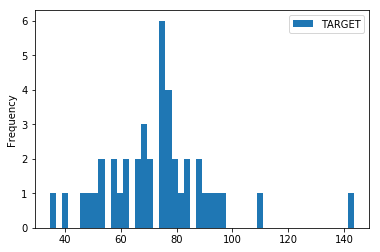

In [15]:
display(modelar[['HY_provincia', 'TARGET']].groupby(by = 'HY_provincia').mean().head(10))
modelar[['HY_provincia', 'TARGET']].groupby(by = 'HY_provincia').mean().plot(kind='hist', bins=50)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


count    9958.000000
mean       74.155855
std        89.738992
min         0.000000
25%        28.655000
50%        56.275000
75%        90.507500
max      1770.000000
Name: TARGET, dtype: float64

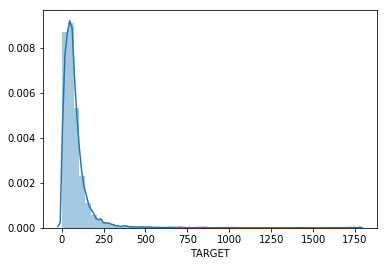

In [16]:
sns.distplot(modelar.TARGET);
modelar['TARGET'].describe()

Se descartan los valores atípicos de la variable objetivo, de manera que se conservan el 98.02% de los datos disponibles.

In [17]:
print(round(modelar.loc[modelar['TARGET']<300,].shape[0]/modelar.shape[0]*100,2),'%')

98.02 %


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


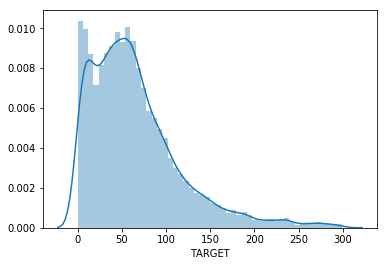

In [18]:
modelar = modelar.loc[modelar['TARGET']<300,]
sns.distplot(modelar.TARGET)

Se almacena el dataframe disponible en este punto, antes de continuar:

In [19]:
# modelar.to_csv('data/modelar_normalized.csv', index = False)

#### Variable: Descripción
***
Se dispone información de la descripción en 5811 muestras (59.53% del total) y 659 muestras del dataset de test (59.69% del total).

In [20]:
modelar['HY_descripcion'].count()

5921

In [21]:
estimar['HY_descripcion'].count()

659

<a id='histograms'></a> 

#### 3.1. Histogramas <p style="text-align: right;"> <a href='#top'>Return to top</a> </p>


In [22]:
modelar = pd.read_csv('data/modelar_normalized.csv')

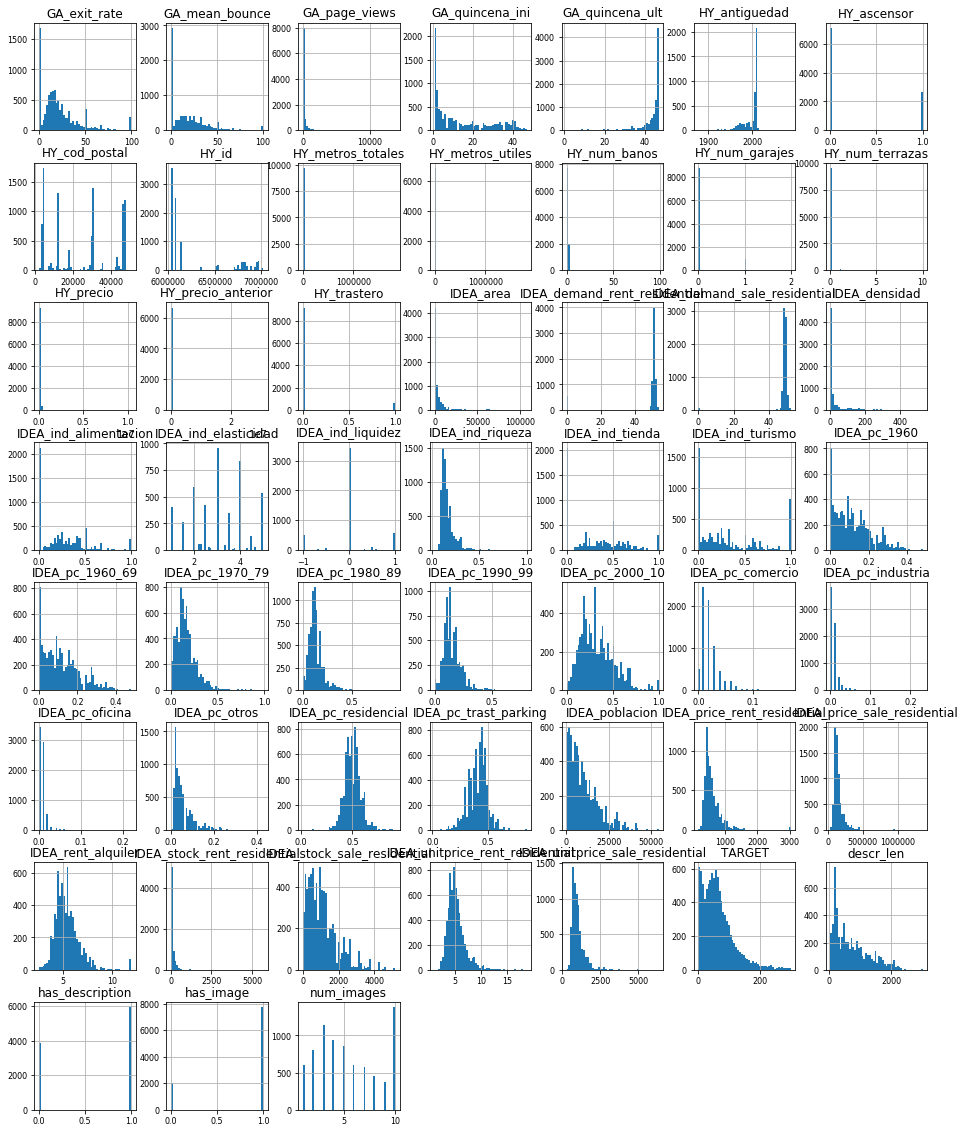

In [23]:
modelar.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)
plt.show()

#### Variable: HY_metros totales
***

In [24]:
modelar.loc[modelar['HY_metros_totales']>10000].head(3)

,HY_id,HY_cod_postal,HY_provincia,HY_descripcion,HY_distribucion,HY_tipo,HY_antiguedad,HY_metros_utiles,HY_metros_totales,HY_num_banos,...,GA_mean_bounce,GA_exit_rate,GA_quincena_ini,GA_quincena_ult,TARGET,num_images,piscina,has_image,descr_len,has_description
1395,6035128,12006,Castellón,Parcela de tipo suelo urbano de forma irregula...,NaN,Solar,NaN,NaN,99999.0,0,...,30.35,23.28,1,47,188.14,4.0,False,1,155.0,1
2922,6042341,4117,Almería,"Parcela de terreno edificable, ubicada en el m...",NaN,Solar,NaN,NaN,14556.0,0,...,31.13,26.11,1,46,108.92,2.0,False,1,92.0,1
2923,6042342,4117,Almería,"Parcela de terreno edificable, ubicada en el m...",NaN,Solar,NaN,NaN,12976.0,0,...,0.00,4.29,1,44,156.05,1.0,False,1,92.0,1


#### Variables: Quincenas (GA_quincena_ini y GA_quincena_ult)
***
Estas variables se refieren a la primera semana del año en la que el anuncio apareció y la última en la que estaba activo. Una variable más interesante puede ser el tiempo que lleva activo un anuncio, puesto que a más tiempo menos interesante puede ser el anuncio.

In [25]:
modelar[['GA_quincena_ini', 'GA_quincena_ult']].head(5)

,GA_quincena_ini,GA_quincena_ult
0,2,46
1,1,47
2,1,47
3,2,47
4,2,39


In [26]:
modelar['active_week'] = modelar['GA_quincena_ult'] - modelar['GA_quincena_ini']

In [27]:
modelar.loc[modelar['HY_precio']>2000000]

,HY_id,HY_cod_postal,HY_provincia,HY_descripcion,HY_distribucion,HY_tipo,HY_antiguedad,HY_metros_utiles,HY_metros_totales,HY_num_banos,...,GA_exit_rate,GA_quincena_ini,GA_quincena_ult,TARGET,num_images,piscina,has_image,descr_len,has_description,active_week
4429,6037826,8202,Barcelona,Local comercial en esquina integrado en dos ed...,"Cuenta con una superficie total de 1076, 64 m²...",Local,1960.0,NaN,2118.53,0,...,50.87,11,47,145.57,2.0,False,1,2031.0,1,36
4437,6038463,4001,Almería,NaN,NaN,Local,NaN,0.0,385.07,0,...,22.20,39,47,50.10,4.0,NaN,1,NaN,0,8
4543,6075912,29730,Málaga,NaN,NaN,Solar,NaN,0.0,10000.00,0,...,51.19,33,45,88.42,2.0,NaN,1,NaN,0,12
6344,6033399,4630,Almería,Terrenos urbanos en el Paraje La Espesura. Tie...,Terreno de superficie registral: 269.116 m².\r...,Solar,NaN,NaN,269116.00,0,...,17.42,1,47,97.46,10.0,False,1,918.0,1,46
8566,6811795,4007,Almería,NaN,NaN,Local,NaN,2200.0,2300.50,0,...,78.33,30,46,46.71,5.0,NaN,1,NaN,0,16
9124,6940987,46980,Valencia,NaN,NaN,Solar,NaN,2538.0,2538.00,0,...,24.17,38,47,38.72,3.0,NaN,1,NaN,0,9
9219,6946638,12520,Castellón,NaN,NaN,Solar,NaN,4226.0,4226.00,0,...,33.33,35,46,170.18,3.0,NaN,1,NaN,0,11
9711,7008680,50270,Zaragoza,NaN,NaN,Solar,NaN,1820000.0,1820000.00,0,...,13.89,39,42,166.80,3.0,NaN,1,NaN,0,3


#### Variable: Certificado energético (HY_cert_energ)
***
A pesar de no disponer de muchos datos de la variable, se observa que no es relevante frente a la variable objetivo

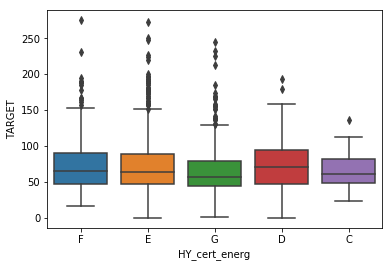

In [28]:
sns.boxplot(data = modelar[['HY_cert_energ', 'TARGET']], x = 'HY_cert_energ', y = 'TARGET')

In [29]:
modelar['HY_cert_energ'].unique()

array([nan, 'F', 'E', 'G', 'D', 'C'], dtype=object)

#### Variable: Ascensor (HY_ascensor)
***

Se observa que no es relevante frente a la variable objetivo

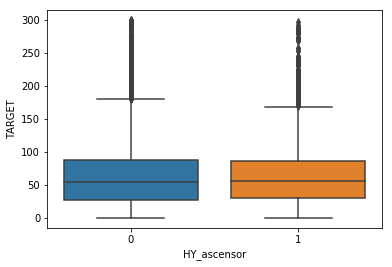

In [30]:
sns.boxplot(data = modelar[['HY_ascensor', 'TARGET']], x = 'HY_ascensor', y = 'TARGET')
plt.show()

#### Variable: Variables de población y densidad
***


In [31]:
def plot_target(column):
    modelar[[column, 'TARGET']].plot(x = column, y = 'TARGET', kind = 'scatter')

In [32]:
def plot_cat_target(column):
    fig, ax = plt.subplots(figsize = (10, 8))
    sns.boxplot(data = modelar[[column, 'TARGET']], x = column, y = 'TARGET')
    plt.xticks(rotation=45)

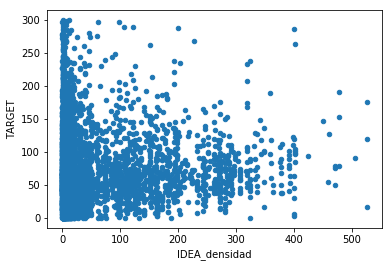

In [33]:
plot_target('IDEA_densidad')

<a id='plotsvstarget'></a> 

#### 3.2. Representación visual de variables frente al 'TARGET' <p style="text-align: right;"> <a href='#top'>Return to top</a> </p>


HY_provincia plot not possible
HY_descripcion plot not possible
HY_distribucion plot not possible
HY_tipo plot not possible
HY_cert_energ plot not possible
num_images plot not possible
piscina plot not possible
has_image plot not possible
descr_len plot not possible
has_description plot not possible
active_week plot not possible


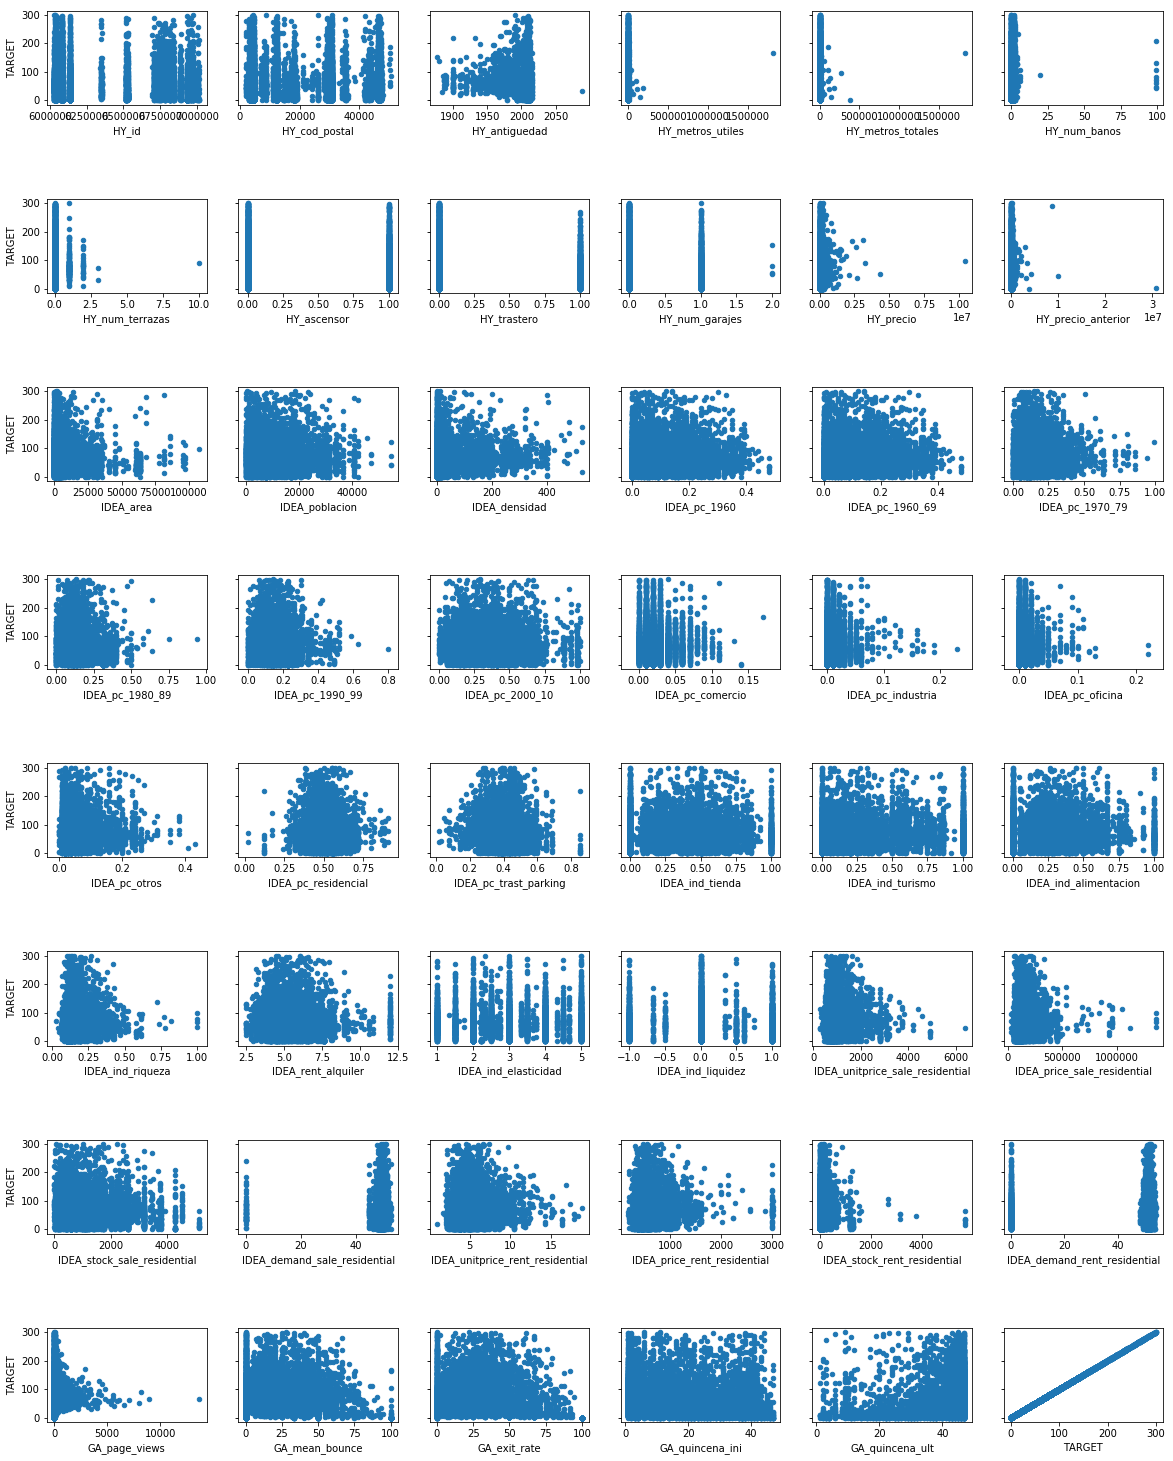

In [34]:
fig, axes = plt.subplots(nrows=8, ncols=6,figsize=(20, 20))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1, wspace=0.2)

j=0
k=0
for i in modelar.columns:
    try:
        modelar[[i, 'TARGET']].plot(x = i, y = 'TARGET', kind = 'scatter',ax=axes[j, k],sharey=True,sharex=False)
        k+=1
        if k==6:
            k=0
            j+=1
    except:
        print(i, 'plot not possible')

<a id='correlationmatrix'></a> 

#### 3.3. Matriz de correlaciones <p style="text-align: right;"> <a href='#top'>Return to top</a> </p>


In [35]:
from sklearn.feature_selection import mutual_info_classif as MIc
from sklearn.feature_selection import mutual_info_regression as MIr

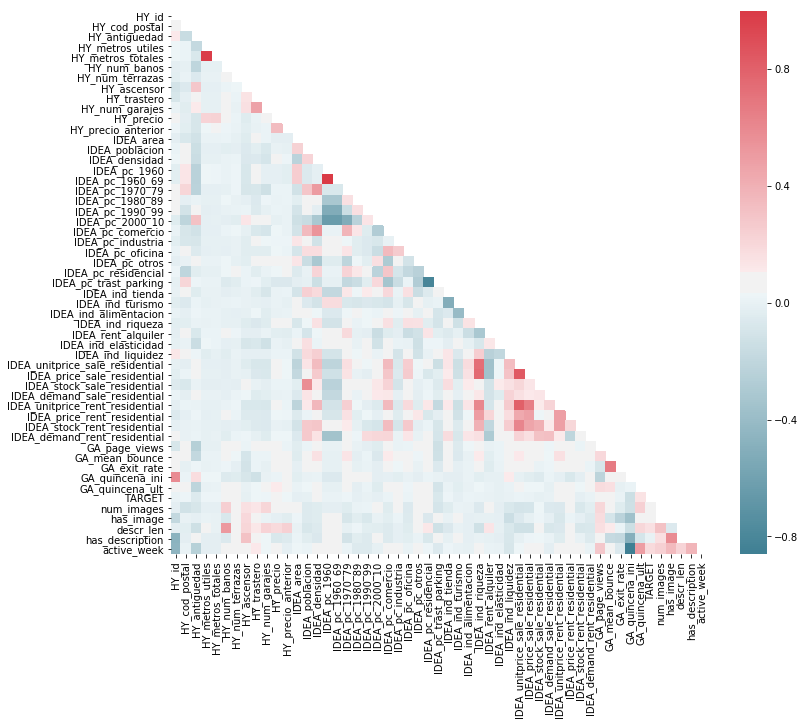

In [36]:
fig, ax = plt.subplots(figsize = (12, 10))
corr_matrix = modelar.corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_matrix, cmap = sns.diverging_palette(220, 10, as_cmap = True), mask = mask)
plt.show()

In [37]:
columnas= modelar.columns

position=[i for i,x in enumerate(columnas) if x == 'HY_precio']
modelar.insert(position[0]+1, '% Descuento', 0)
modelar['% Descuento'] = np.where(modelar['HY_precio_anterior']>0, 100*round(((modelar['HY_precio']-modelar['HY_precio_anterior'])/modelar['HY_precio_anterior']),4), 0)
modelar[['HY_precio','HY_precio_anterior','% Descuento']].head()

,HY_precio,HY_precio_anterior,% Descuento
0,12300.0,NaN,0.00
1,115000.0,125000.0,-8.00
2,88000.0,93500.0,-5.88
3,5800.0,NaN,0.00
4,7400.0,NaN,0.00


Al tener, la información que aporta *HY_precio_anterior* en una nueva columna *% Descuento*, se procede a eliminarla:

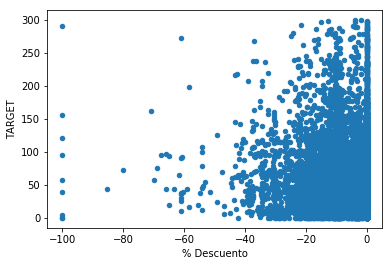

In [38]:
plot_target('% Descuento')

In [39]:
modelar.drop(['HY_precio_anterior'], axis=1, inplace = True)

<a id='categoricalvariables'></a> 

#### 3.4. Variables categóricas <p style="text-align: right;"> <a href='#top'>Return to top</a> </p>


#### Variable: Piscina

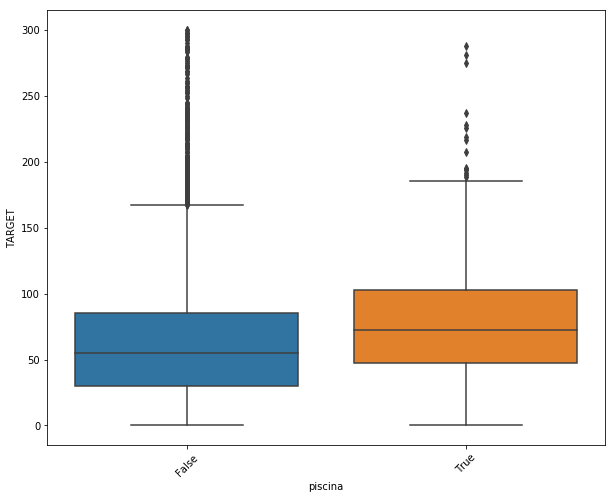

In [40]:
plot_cat_target('piscina')

#### Variable: Tipo de anuncio (HY_tipo)
***
Debido a la gran variedad de clases disponibles (20), se procede a la reducción de la cantidad de las mismas en este apartado, atendiendo a diferentes criterios y al contenido de la descripción.

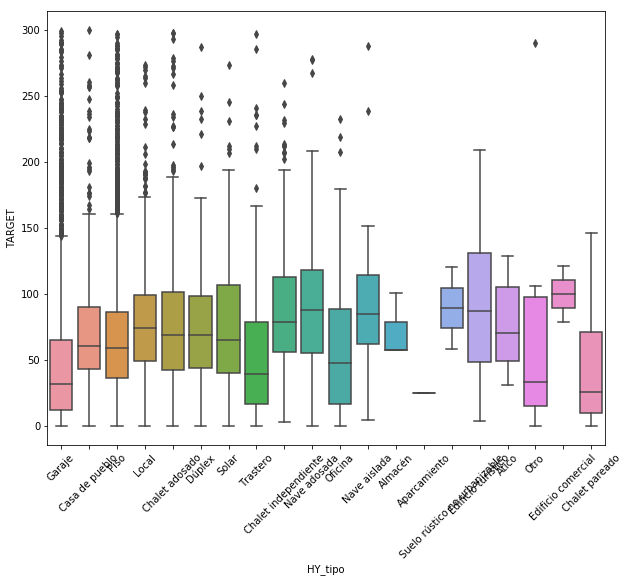

In [41]:
plot_cat_target('HY_tipo')

In [42]:
modelar[['HY_tipo', 'TARGET']].groupby(['HY_tipo']).agg('count')

,TARGET
HY_tipo,
Almacén,3
Aparcamiento,1
Casa de pueblo,551
Chalet adosado,426
Chalet independiente,208
Chalet pareado,8
Dúplex,180
Edificio comercial,2
Edificio turístico,17


In [43]:
modelar.loc[modelar['HY_tipo']=='Aparcamiento', 'HY_descripcion'].values

array(['Plaza de aparcamiento en superficie, ubicada en el municipio de Fondón, en la provincia de Almería. en una calle peatonal, cerca del centro histórico de la ciudad. El edificio se encuentra en una zona tranquila y cuenta con buenos accesos por carretera y con un nivel alto de servicios y comunicaciones, rodeado de edificios de las mismas características.'],
      dtype=object)

In [44]:
def change_labels(column, old_label, new_label):
    modelar.loc[modelar[column] == old_label, column] = new_label

In [45]:
change_labels('HY_tipo', 'Aparcamiento', 'Garaje')

In [46]:
modelar.loc[modelar['HY_tipo']=='Edificio comercial', 'HY_descripcion'].values

array([nan,
       'Se trata de un edificio unifamiliar con planta baja y primer piso.'],
      dtype=object)

In [47]:
change_labels('HY_tipo', 'Ático', 'Piso')

In [48]:
modelar.loc[modelar['HY_tipo']=='Suelo rústico no urbanizable', 'HY_descripcion'].values

array(['Terreno urbano de dos hectáreas cuarenta y seis áreas, sobre la que existe una edificación de un chalet aislado compuesto por cuatro dormitorios y un baño. Se encuentra ubicado en el municipio de Chelva, provincia de Valencia.Vivienda distribuida en dos plantas. La planta baja cuenta con un almacén. La planta alta cuenta con cuatro dormitorios, dos baños, un salón comedor con cocina y una terraza.Es un terreno urbano sobre el que existe una edificación de un chalet asilado.Terreno urbano con una edificación de un chalet aislado de dos plantas sobre rasante. Su año de construcción es 1992 y se encuentra ubicado en una zona tranquila. Zona que dispone de centros de educación y ocio, comercios y actividades culturales.Zona con fácil acceso por carretera (N332, CV5040 y CV605), líneas de autobús (urbano e interurbano) y estación de tren (Cercanías Cullera). Cuenta con centros educativos, escuelas infantiles (Escuela Infantil Inmaculada Concepción), colegios públicos (Colegio Públic

In [49]:
change_labels('HY_tipo', 'Suelo rústico no urbanizable', 'Solar')

In [50]:
change_labels('HY_tipo', 'Nave aislada', 'Nave adosada')

In [51]:
change_labels('HY_tipo', 'Edificio comercial', 'Local')

In [52]:
change_labels('HY_tipo', 'Dúplex', 'Piso')

In [53]:
modelar.loc[modelar['HY_tipo']=='Almacén', 'HY_descripcion'].values

array(['Almacén ubicado en la planta baja de un edificio de tres alturas sobre rasante, dos plantas destinadas a viviendas. Se encuentra ubicado en la localidad de Carboneras, provincia de Almería.\r\nEl almacen se distribuye en una estancia diáfana y cuenta con una superficie construida de 58.62 m2 y útil de 54,59m2\r\nEdificio de viviendas de tres alturas sobre rasante, la planta baja destinada a almacén y dos plantas a viviendas. Es del año 1997 y se encuentra ubicado en el municipio de Carboneras a pocos minutos de la playa.\r\nZona con buena comunicación por carretera ( Al-5105, AL-5107) y autobuses urbanos. Cuenta con Hotel Trebol, restauración, centro de salud, centro de buceo, club náutico, ayuntamiento, bancos, supermercados, polideportivo municipal. Cuenta como lugar de interés el Castillo de San Andrés, el Molino de Carboneras y la playa del Lancon.\r\n',
       'Local comercial de una planta de 182 m² construidos, situado en Castellón de la Plana. Se sitúa en la planta baja

In [54]:
change_labels('HY_tipo', 'Chalet pareado', 'Chalet')
change_labels('HY_tipo', 'Chalet independiente', 'Chalet')
change_labels('HY_tipo', 'Chalet adosado', 'Chalet')

In [55]:
modelar.loc[(modelar['HY_tipo'] == 'Almacén') & 
            (modelar['HY_descripcion'] == 'Nave compuesta de una planta, situada en la localidad de Nules, provincia de Castellón.Consta de una superficie de 2654, 74 m².Está compuesta de una planta y se encuentra diáfana. Tiene estructura de metal y placas traslucidas en el techo.La nave se encuentra rodeada por edificaciones y naves de similares características.Tiene una antigüedad del año 1972. A 18 km de Castellón, cuenta con fácil acceso a través de la carretera CV-231 que enlaza con la autovía A-7. Está próxima al Teatro Alcázar, los Juzgados de Nules, y de la estación de Renfe de Cercanías de Nules- La Vilavella y a su alrededor encontrar gran variedad de servicios como comercios, centros educativos, centros de salud, farmacias, cajeros, bares y restaurantes. Nules es una localidad costera del sur de la provincia de Castellón, localizada en la comarca de la Plana Baja. Su clima es mediterráneo. Nules dispone de un amplio litoral, de unos 5 km de longitud que junto a la playa de Nules, es un ejemplo deplaya sostenible y sin aglomeraciones, Además, se puede visitar el paraje natural del Estany de Nules, una laguna de agua dulce habitada por numerosas especies de aves y peces.'), 'HY_tipo'] = 'Nave'

In [56]:
modelar.loc[(modelar['HY_tipo'] == 'Almacén') & 
            (modelar['HY_descripcion'] == 'Local comercial de una planta de 182 m² construidos, situado en Castellón de la Plana. Se sitúa en la planta baja de un edificio residencial de diez alturas y dos plantas sobre rasante incluido garaje.El local consta de una planta, con vestíbulo, aseo y garaje, teniendo una superficie de 182 m² construidos. Se trata de un local en buen estado de conservación y con buena accesibilidad. Posee un vestíbulo, aseo y garaje. El inmueble posee persianas de aluminio y en el aseo porcelana vitrificada blanca. El local se localiza en la planta baja de un edificio residencial de diez plantas sobre rasante y se haya rodeado de locales y viviendas de similarescaracterísticas. Su año de construcción es 1997. Se encuentra ubicado en la ciudad de Castellón de la Plana, en zona tranquila a 10 min del centroCastellón de la Plana es una ciudad y municipio español, capital de la provincia de Castellón y de la comarca, situado en la Comunidad Valenciana. Situado al este de la península sobre una extensión de terreno llano, rodeada por distintas sierras por el interior y el mar Mediterráneo al este, ante el cual se extienden los 10 kilómetros de costa. El núcleo urbano principal se encuentra a unos 30 m sobre el nivel del mar y a unos 4 km de la costa. Castellón se encuentra comunicada con el resto de la península a través de la Autopista AP-7 que cruza la provincia de norte a sur, y por la carretera nacional paralela, la N-340 que comunica todo el mediterráneo español.  Hacia el interior de la península A-23 comunica Valencia con Aragón y la N-232, hasta Soria, pasando por Morella. Las conexiones ferroviarias recorren Valencia, Alicante y Madrid, como con Tarragona, Barcelona y Europa. Además, posee una gran variedad de medios de transporte a través de los cuales puedes moverte por toda la ciudad de manera rápida y cómoda. Dispone de 12 líneas y de los autobuses urbanos para desplazamientos y red de tram. El local cuenta en las cercanías con varias líneas de autobuses (L-8, L-11, L-4 y L-17), además de multitud de comercios y restaurantes, centros educativos (IES el Caminas),  hospitales (Hospital provincial de Castellón), centros comerciales cercanos y comisarias.'), 'HY_tipo'] = 'Local'

In [57]:
modelar.loc[(modelar['HY_tipo'] == 'Almacén') & 
            (modelar['HY_descripcion'] == 'Almacén ubicado en la planta baja de un edificio de tres alturas sobre rasante, dos plantas destinadas a viviendas. Se encuentra ubicado en la localidad de Carboneras, provincia de Almería.\r\nEl almacen se distribuye en una estancia diáfana y cuenta con una superficie construida de 58.62 m2 y útil de 54,59m2\r\nEdificio de viviendas de tres alturas sobre rasante, la planta baja destinada a almacén y dos plantas a viviendas. Es del año 1997 y se encuentra ubicado en el municipio de Carboneras a pocos minutos de la playa.\r\nZona con buena comunicación por carretera ( Al-5105, AL-5107) y autobuses urbanos. Cuenta con Hotel Trebol, restauración, centro de salud, centro de buceo, club náutico, ayuntamiento, bancos, supermercados, polideportivo municipal. Cuenta como lugar de interés el Castillo de San Andrés, el Molino de Carboneras y la playa del Lancon.\r\n'), 'HY_tipo'] = 'Local'

In [58]:
change_labels('HY_tipo', 'Nave adosada', 'Nave')

In [59]:
change_labels('HY_tipo', 'Edificio turístico', 'Otro')

In [60]:
modelar[['HY_tipo', 'TARGET']].groupby(['HY_tipo']).agg('count')

,TARGET
HY_tipo,
Casa de pueblo,551
Chalet,642
Garaje,2692
Local,817
Nave,159
Oficina,94
Otro,29
Piso,4307
Solar,197


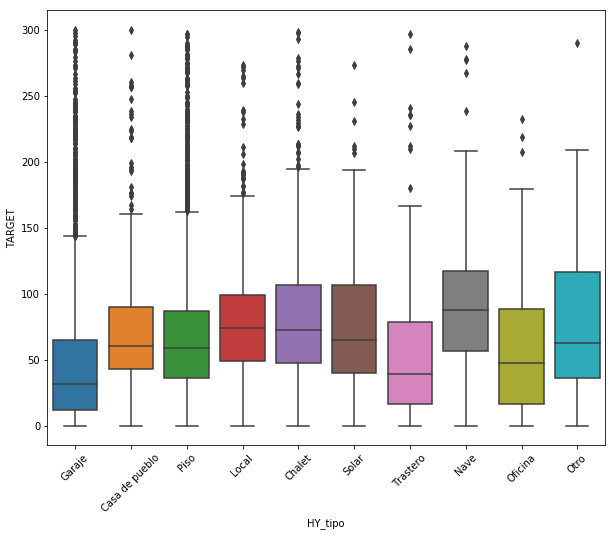

In [61]:
plot_cat_target('HY_tipo')

<a id='dataprep'></a> 

### 4. Preparación de los datos <p style="text-align: right;"> <a href='#top'>Return to top</a> </p>


<a id='fillna'></a> 

#### 4.1. Imputación de valores no disponibles <p style="text-align: right;">

In [62]:
cols = modelar.columns.tolist()

In [63]:
idealista_vars = [col for col in cols if col[:4]=='IDEA']

In [64]:
idealista_vars.append('HY_provincia')

In [65]:
to_fill_missing_values_prov = modelar[idealista_vars].groupby(by = 'HY_provincia').agg(['median'])

In [66]:
to_fill_missing_values_prov

,IDEA_area,IDEA_poblacion,IDEA_densidad,IDEA_pc_1960,IDEA_pc_1960_69,IDEA_pc_1970_79,IDEA_pc_1980_89,IDEA_pc_1990_99,IDEA_pc_2000_10,IDEA_pc_comercio,...,IDEA_ind_elasticidad,IDEA_ind_liquidez,IDEA_unitprice_sale_residential,IDEA_price_sale_residential,IDEA_stock_sale_residential,IDEA_demand_sale_residential,IDEA_unitprice_rent_residential,IDEA_price_rent_residential,IDEA_stock_rent_residential,IDEA_demand_rent_residential
,median,median,median,median,median,median,median,median,median,median,...,median,median,median,median,median,median,median,median,median,median
HY_provincia,,,,,,,,,,,,,,,,,,,,,
A Coruña,223.510,11517.0,51.530,0.08,0.08,0.27,0.200,0.070,0.310,0.060,...,1.000000,0.000000,1848.910,198996.670,1071.0,49.210,8.120,1015.560,195.0,51.920
Albacete,40458.930,11882.0,0.340,0.05,0.05,0.15,0.085,0.160,0.310,0.010,...,2.333333,0.000000,1354.280,201047.060,1188.0,48.780,5.020,663.360,339.0,50.530
Alicante,1916.890,7593.0,3.380,0.11,0.11,0.17,0.130,0.130,0.260,0.030,...,3.000000,0.000000,940.320,129370.000,1083.0,49.100,4.640,564.445,54.0,51.550
Almería,1356.920,8300.0,4.260,0.01,0.01,0.10,0.140,0.180,0.460,0.020,...,3.000000,0.000000,933.060,116817.690,999.0,49.210,4.590,447.690,45.0,51.400
Asturias,119.450,15246.0,127.640,0.09,0.09,0.40,0.120,0.120,0.200,0.050,...,4.000000,0.000000,1595.080,287118.750,1575.0,49.090,7.590,575.140,489.0,50.530
Avila,79.560,5594.0,92.790,0.12,0.12,0.24,0.200,0.210,0.120,0.030,...,1.500000,0.000000,867.580,103582.500,918.0,49.180,5.060,488.730,96.0,51.380
Badajoz,91.560,4530.0,49.480,0.05,0.05,0.09,0.340,0.100,0.380,0.010,...,NaN,NaN,677.510,79134.620,123.0,48.690,NaN,NaN,NaN,0.000
Baleares,2352.540,8229.0,2.160,0.27,0.27,0.09,0.090,0.070,0.200,0.020,...,2.500000,0.000000,1395.740,214085.750,828.0,50.200,7.340,1084.705,153.0,51.800


In [67]:
to_fill_missing_values = modelar.loc[modelar['HY_provincia'].notnull(), idealista_vars].mean()

In [68]:
idealista_vars = [col for col in cols if col[:4]=='IDEA']
provincias = to_fill_missing_values_prov.index.values.tolist()

In [69]:
for col in idealista_vars:
    for provincia in provincias:
        modelar.loc[(modelar['HY_provincia'] == provincia) & (modelar[col].isnull()), col] = to_fill_missing_values_prov.loc[provincia, col].values[0]

In [70]:
modelar = modelar.loc[modelar['IDEA_pc_1960'].notnull()]

In [71]:
to_fill_missing_values_tipo = modelar[['HY_metros_totales', 'HY_tipo']].groupby(by = 'HY_tipo').agg(['median'])
to_fill_missing_values_tipo

,HY_metros_totales
,median
HY_tipo,
Casa de pueblo,131.000
Chalet,150.265
Garaje,25.000
Local,134.580
Nave,597.850
Oficina,114.000
Otro,372.000
Piso,88.710


In [72]:
tipos = to_fill_missing_values_tipo.index.values.tolist()

In [73]:
for tipo in tipos:
        modelar.loc[(modelar['HY_tipo'] == tipo) & (modelar['HY_metros_totales'].isnull()), 'HY_metros_totales'] = to_fill_missing_values_tipo.loc[tipo, 'HY_metros_totales'].values[0]

In [74]:
modelar.loc[modelar['IDEA_rent_alquiler'].isnull(), 'IDEA_rent_alquiler'] = modelar['IDEA_rent_alquiler'].median()

In [75]:
modelar = modelar[modelar['IDEA_unitprice_rent_residential'].notnull()]

In [76]:
modelar.loc[modelar['descr_len'].isnull(), 'descr_len'] = 0

In [77]:
modelar.loc[modelar['piscina'].isnull(), 'piscina'] = 0
modelar.loc[modelar['piscina'] == False, 'piscina'] = 0
modelar.loc[modelar['piscina'] == True, 'piscina'] = 1

In [78]:
modelar.loc[modelar['num_images'].isnull(), 'num_images'] = 0

#### Variable de precio por metro cuadrado relativo a la zona
A continuación generamos una nueva variable que puede ser interesante para medir el interés sobre un inmueble. Se basa en calcular la diferencia de precio del metro cuadrado en la zona con el metro cuadrado del inmueble.

In [79]:
modelar['diff_precio_zona'] = ((modelar['HY_precio']/modelar['HY_metros_totales'])-modelar['IDEA_price_sale_residential'])/modelar['IDEA_price_sale_residential']

In [80]:
modelar = modelar.loc[modelar['diff_precio_zona'].notnull()]

In [81]:
modelar.isnull().sum()

HY_id                                 0
HY_cod_postal                         0
HY_provincia                         41
HY_descripcion                     3837
HY_distribucion                    6580
HY_tipo                               0
HY_antiguedad                      5355
HY_metros_utiles                   2832
HY_metros_totales                     0
HY_num_banos                          0
HY_cert_energ                      8100
HY_num_terrazas                       0
HY_ascensor                           0
HY_trastero                           0
HY_num_garajes                        0
HY_precio                             0
% Descuento                           0
IDEA_area                             0
IDEA_poblacion                        0
IDEA_densidad                         0
IDEA_pc_1960                          0
IDEA_pc_1960_69                       0
IDEA_pc_1970_79                       0
IDEA_pc_1980_89                       0
IDEA_pc_1990_99                       0


<a id='dropvariables'></a> 

#### 4.3. Eliminación de atributos sin relevancia <p style="text-align: right;"> <a href='#top'>Return to top</a> </p>


In [82]:
modelar_clean = modelar.drop(['HY_descripcion','HY_distribucion','HY_cod_postal','HY_provincia',
                            'HY_cert_energ','HY_ascensor', 'HY_antiguedad', 'HY_metros_utiles',
                            'IDEA_ind_elasticidad', 'IDEA_ind_liquidez', 'GA_quincena_ini', 'GA_quincena_ult'],axis=1)

In [83]:
# modelar_clean.to_csv('data/modelar_clean.csv')

In [84]:
modelar_clean.drop('HY_id', axis=1, inplace=True)

In [85]:
modelar_clean.isnull().sum()

HY_tipo                            0
HY_metros_totales                  0
HY_num_banos                       0
HY_num_terrazas                    0
HY_trastero                        0
HY_num_garajes                     0
HY_precio                          0
% Descuento                        0
IDEA_area                          0
IDEA_poblacion                     0
IDEA_densidad                      0
IDEA_pc_1960                       0
IDEA_pc_1960_69                    0
IDEA_pc_1970_79                    0
IDEA_pc_1980_89                    0
IDEA_pc_1990_99                    0
IDEA_pc_2000_10                    0
IDEA_pc_comercio                   0
IDEA_pc_industria                  0
IDEA_pc_oficina                    0
IDEA_pc_otros                      0
IDEA_pc_residencial                0
IDEA_pc_trast_parking              0
IDEA_ind_tienda                    0
IDEA_ind_turismo                   0
IDEA_ind_alimentacion              0
IDEA_ind_riqueza                   0
I

<a id='dummies'></a> 

#### 4.2. Variables Dummy <p style="text-align: right;"> <a href='#top'>Return to top</a> </p>


In [86]:
categorical_cols = ['HY_tipo']

In [87]:
modelar_clean = pd.get_dummies(modelar_clean, prefix=None, prefix_sep='_', dummy_na=False, columns=categorical_cols)

<a id='featureselection'></a> 

### 5. Selección de variables <p style="text-align: right;"> <a href='#top'>Return to top</a> </p>


In [88]:
y = modelar_clean['TARGET']
X = modelar_clean.drop('TARGET', axis = 1)

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [90]:
# with open('data/train_test/X_train.npy', 'w') as f:
#     np.save('data/train_test/X_train.npy',X_train)
# with open('data/train_test/y_train.npy', 'w') as f:
#     np.save('data/train_test/y_train.npy',y_train)
# with open('data/train_test/X_test.npy', 'w') as f:
#     np.save('data/train_test/X_test.npy',X_test)
# with open('data/train_test/y_test.npy', 'w') as f:
#     np.save('data/train_test/y_test.npy',y_test)

In [91]:
rf_model = RandomForestRegressor(n_estimators = 500, criterion = 'mse', min_samples_split = 8)

In [92]:
rf_model.fit(X_train, y_train)
print(rf_model.feature_importances_)

[6.13933320e-02 6.37165271e-03 1.37382196e-03 3.00250578e-03
 1.95466023e-03 5.10986204e-02 4.24394870e-02 1.66237499e-02
 1.71529550e-02 1.34710984e-02 4.68800578e-03 4.69563847e-03
 1.23352918e-02 1.45148070e-02 1.18876943e-02 1.33758442e-02
 5.39639811e-03 9.31504993e-03 4.64678205e-03 1.55010427e-02
 1.15905851e-02 1.21458838e-02 1.21822752e-02 1.04797706e-02
 1.26923925e-02 7.93665020e-03 1.76894182e-02 1.18858671e-02
 1.44260318e-02 1.62589657e-02 1.69064367e-02 1.41467585e-02
 1.62234671e-02 1.24385960e-02 1.67581430e-02 1.55970478e-01
 3.02862286e-02 1.12132546e-01 1.98347455e-02 3.82899252e-03
 2.69626509e-03 3.30375861e-02 9.68808683e-04 5.29223911e-02
 5.63651296e-02 1.74729718e-03 3.70133371e-03 1.72690336e-03
 2.93773313e-03 2.50603146e-03 2.40186297e-04 1.39886309e-04
 2.23011092e-03 5.06325459e-04 1.22134123e-03]


In [93]:
names = X.columns.tolist()
important_features = sorted(zip(map(lambda x: round(x, 4), rf_model.feature_importances_), names), reverse=True)
print(important_features)

[(0.156, 'GA_page_views'), (0.1121, 'GA_exit_rate'), (0.0614, 'HY_metros_totales'), (0.0564, 'diff_precio_zona'), (0.0529, 'active_week'), (0.0511, 'HY_precio'), (0.0424, '% Descuento'), (0.033, 'descr_len'), (0.0303, 'GA_mean_bounce'), (0.0198, 'num_images'), (0.0177, 'IDEA_rent_alquiler'), (0.0172, 'IDEA_poblacion'), (0.0169, 'IDEA_demand_sale_residential'), (0.0168, 'IDEA_demand_rent_residential'), (0.0166, 'IDEA_area'), (0.0163, 'IDEA_stock_sale_residential'), (0.0162, 'IDEA_price_rent_residential'), (0.0155, 'IDEA_pc_otros'), (0.0145, 'IDEA_pc_1980_89'), (0.0144, 'IDEA_price_sale_residential'), (0.0141, 'IDEA_unitprice_rent_residential'), (0.0135, 'IDEA_densidad'), (0.0134, 'IDEA_pc_2000_10'), (0.0127, 'IDEA_ind_alimentacion'), (0.0124, 'IDEA_stock_rent_residential'), (0.0123, 'IDEA_pc_1970_79'), (0.0122, 'IDEA_ind_tienda'), (0.0121, 'IDEA_pc_trast_parking'), (0.0119, 'IDEA_unitprice_sale_residential'), (0.0119, 'IDEA_pc_1990_99'), (0.0116, 'IDEA_pc_residencial'), (0.0105, 'IDEA_i

<BarContainer object of 55 artists>

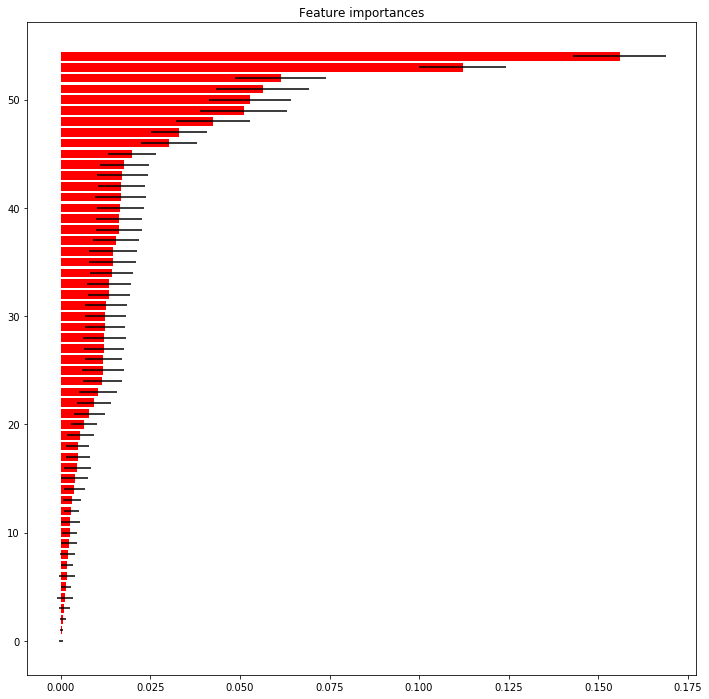

In [94]:
plt.figure(figsize = (12,12))
plt.title("Feature importances")
indices = np.argsort(rf_model.feature_importances_)
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_],
             axis=0)
plt.barh(range(X.shape[1]), rf_model.feature_importances_[indices], color="r", xerr=std[indices], align="center")

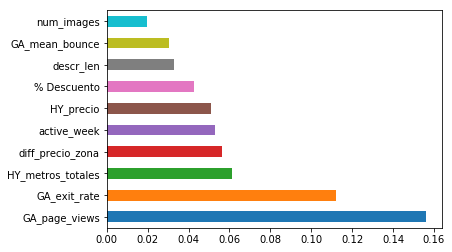

In [95]:
(pd.Series(rf_model.feature_importances_, index=X.columns)
   .nlargest(10)
   .plot(kind='barh'))

<a id='model'></a> 

### 6. Selección y entrenamiento del modelo <p style="text-align: right;"> <a href='#top'>Return to top</a> </p>


In [96]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [97]:
important_feature_names = [feature[1] for feature in important_features]

In [98]:
num_feat = 54
important_feature_names[:num_feat]

['GA_page_views',
 'GA_exit_rate',
 'HY_metros_totales',
 'diff_precio_zona',
 'active_week',
 'HY_precio',
 '% Descuento',
 'descr_len',
 'GA_mean_bounce',
 'num_images',
 'IDEA_rent_alquiler',
 'IDEA_poblacion',
 'IDEA_demand_sale_residential',
 'IDEA_demand_rent_residential',
 'IDEA_area',
 'IDEA_stock_sale_residential',
 'IDEA_price_rent_residential',
 'IDEA_pc_otros',
 'IDEA_pc_1980_89',
 'IDEA_price_sale_residential',
 'IDEA_unitprice_rent_residential',
 'IDEA_densidad',
 'IDEA_pc_2000_10',
 'IDEA_ind_alimentacion',
 'IDEA_stock_rent_residential',
 'IDEA_pc_1970_79',
 'IDEA_ind_tienda',
 'IDEA_pc_trast_parking',
 'IDEA_unitprice_sale_residential',
 'IDEA_pc_1990_99',
 'IDEA_pc_residencial',
 'IDEA_ind_turismo',
 'IDEA_pc_industria',
 'IDEA_ind_riqueza',
 'HY_num_banos',
 'IDEA_pc_comercio',
 'IDEA_pc_1960_69',
 'IDEA_pc_1960',
 'IDEA_pc_oficina',
 'piscina',
 'HY_tipo_Chalet',
 'HY_trastero',
 'HY_tipo_Local',
 'has_image',
 'HY_tipo_Nave',
 'HY_tipo_Piso',
 'HY_num_garajes',
 'H

In [99]:
features_index = [X.columns.get_loc(feature) for feature in important_feature_names[:num_feat]]

In [100]:
X_train_xgb = X_train.iloc[:,features_index]
X_test_xgb = X_test.iloc[:, features_index]

In [101]:
params = {
        'min_child_weight': [1, 5, 10],
        'learning_rate': [0.001, 0.01, 0.1,0.3,0.5,0.7],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.4, 0.6, 0.8, 1.0],
        'colsample_bytree': [0.4, 0.6, 0.8, 1.0],
        'max_depth': [2, 3, 4, 5, 8]
        }

GSxgb = GridSearchCV(estimator = xgb.XGBRegressor(n_estimators=100), 
                       param_grid = params, scoring = 'neg_mean_squared_error', n_jobs=4, iid=False, cv=3)
GSxgb.fit(X_train_xgb,y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'min_child_weight': [1, 5, 10], 'learning_rate': [0.001, 0.01, 0.1, 0.3, 0.5, 0.7], 'gamma': [0.5, 1, 1.5, 2, 5], 'subsample': [0.4, 0.6, 0.8, 1.0], 'colsample_bytree': [0.4, 0.6, 0.8, 1.0], 'max_depth': [2, 3, 4, 5, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [122]:
print('\n Best estimator:')
print(GSxgb.best_estimator_)
print(GSxgb.best_params_)
print(GSxgb.best_score_)


 Best estimator:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.5, learning_rate=0.1,
       max_delta_step=0, max_depth=4, min_child_weight=10, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8)
{'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.8}
-2226.3936446448765


In [102]:
ypred = GSxgb.predict(X_test_xgb)
ypred[ypred<0]=0

In [103]:
from math import sqrt
from sklearn.metrics import mean_squared_error, median_absolute_error
rms = sqrt(mean_squared_error(y_test, ypred))
mae = median_absolute_error(y_test, ypred)
print(rms)
print('MAE =', mae)

48.44101398436127
MAE = 24.581684951782226


Text(0,0.5,'Predicción')

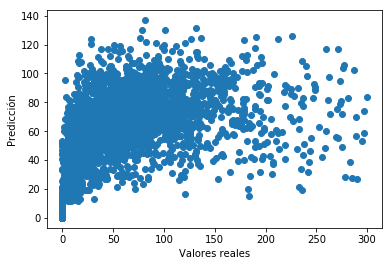

In [104]:
plt.scatter(y_test, ypred)
plt.xlabel('Valores reales')
plt.ylabel('Predicción')

In [105]:
GSxgb.best_estimator_.save_model('models/xgbRegressor_with_high.model')

In [3]:
'''# Importing the libraries
import numpy as np
import pandas as pd
import xgboost as xgb'''

#Se inicializa la población aleatoriamente
def initilialize_poplulation(numberOfParents):
    learningRate = np.empty([numberOfParents, 1])
    nEstimators = np.empty([numberOfParents, 1], dtype = np.uint8)
    maxDepth = np.empty([numberOfParents, 1], dtype = np.uint8)
    minChildWeight = np.empty([numberOfParents, 1])
    gammaValue = np.empty([numberOfParents, 1])
    subSample = np.empty([numberOfParents, 1])
    colSampleByTree =  np.empty([numberOfParents, 1])
    for i in range(numberOfParents):
        print(i)
        learningRate[i] = round(random.uniform(0.01, 1), 2)
        nEstimators[i] = random.randrange(10, 1500, step = 25)
        maxDepth[i] = int(random.randrange(1, 10, step= 1))
        minChildWeight[i] = round(random.uniform(0.01, 10.0), 2)
        gammaValue[i] = round(random.uniform(0.01, 10.0), 2)
        subSample[i] = round(random.uniform(0.01, 1.0), 2)
        colSampleByTree[i] = round(random.uniform(0.01, 1.0), 2)  
    population = np.concatenate((learningRate, nEstimators, maxDepth, minChildWeight, gammaValue, subSample, colSampleByTree), axis= 1)
    return population

#Función de evaluación
def fitness_mae(y_true, y_pred):
    fitness = round(median_absolute_error(y_test, ypred),4)
    return fitness

#train the data annd find fitness score
def train_population(population,X_train,y_train ,X_test , y_test):
    Score = []
    for i in range(population.shape[0]):
        param = { 'objective':'reg:linear',
                 'learning_rate': population[i][0],
                 'n_estimators': population[i][1], 
                 'max_depth': int(population[i][2]), 
                 'min_child_weight': population[i][3],
                 'gamma': population[i][4], 
                 'subsample': population[i][5],
                 'colsample_bytree': population[i][6],
                 'seed': 24}
        num_round = 100
        
        xgb = xgboost.XGBRegressor(param)
        xgb.fit(X_train,y_train)
        preds = xgb.predict(X_test)
        preds[preds<0]=0
        Score.append(fitness_mae(y_test, preds))
    return Score

#select parents for mating
def new_parents_selection(population, fitness, numParents):
    selectedParents = np.empty((numParents, population.shape[1])) #create an array to store fittest parents
    
    #find the top best performing parents
    for parentId in range(numParents):
        bestFitnessId = np.where(fitness == np.max(fitness))
        bestFitnessId  = bestFitnessId[0][0]
        selectedParents[parentId, :] = population[bestFitnessId, :]
        fitness[bestFitnessId] = -1 #set this value to negative, in case of F1-score, so this parent is not selected again
    return selectedParents


'''
Mate these parents to create children having parameters from these parents (we are using uniform crossover method)
'''
def crossover_uniform(parents, childrenSize):
    
    crossoverPointIndex = np.arange(0, np.uint8(childrenSize[1]), 1, dtype= np.uint8) #get all the index
    crossoverPointIndex1 = np.random.randint(0, np.uint8(childrenSize[1]), np.uint8(childrenSize[1]/2)) # select half  of the indexes randomly
    crossoverPointIndex2 = np.array(list(set(crossoverPointIndex) - set(crossoverPointIndex1))) #select leftover indexes
    
    children = np.empty(childrenSize)
    
    '''
    Create child by choosing parameters from two parents selected using new_parent_selection function. The parameter values
    will be picked from the indexes, which were randomly selected above. 
    '''
    for i in range(childrenSize[0]):
        
        #find parent 1 index 
        parent1_index = i%parents.shape[0]
        #find parent 2 index
        parent2_index = (i+1)%parents.shape[0]
        #insert parameters based on random selected indexes in parent 1
        children[i, crossoverPointIndex1] = parents[parent1_index, crossoverPointIndex1]
        #insert parameters based on random selected indexes in parent 1
        children[i, crossoverPointIndex2] = parents[parent2_index, crossoverPointIndex2]
    return children

def mutation(crossover, numberOfParameters):
    #Define minimum and maximum values allowed for each parameter
    minMaxValue = np.zeros((numberOfParameters, 2))
    
    minMaxValue[0:] = [0.01, 1.0] #min/max learning rate
    minMaxValue[1, :] = [10, 2000] #min/max n_estimator
    minMaxValue[2, :] = [1, 15] #min/max depth
    minMaxValue[3, :] = [0, 10.0] #min/max child_weight
    minMaxValue[4, :] = [0.01, 10.0] #min/max gamma
    minMaxValue[5, :] = [0.01, 1.0] #min/maxsubsample
    minMaxValue[6, :] = [0.01, 1.0] #min/maxcolsample_bytree
 
    # Mutation changes a single gene in each offspring randomly.
    mutationValue = 0
    parameterSelect = np.random.randint(0, 7, 1)
    print(parameterSelect)
    if parameterSelect == 0: #learning_rate
        mutationValue = round(np.random.uniform(-0.5, 0.5), 2)
    if parameterSelect == 1: #n_estimators
        mutationValue = np.random.randint(-200, 200, 1)
    if parameterSelect == 2: #max_depth
        mutationValue = np.random.randint(-5, 5, 1)
    if parameterSelect == 3: #min_child_weight
        mutationValue = round(np.random.uniform(5, 5), 2)
    if parameterSelect == 4: #gamma
        mutationValue = round(np.random.uniform(-2, 2), 2)
    if parameterSelect == 5: #subsample
        mutationValue = round(np.random.uniform(-0.5, 0.5), 2)
    if parameterSelect == 6: #colsample
        mutationValue = round(np.random.uniform(-0.5, 0.5), 2)
  
    #indtroduce mutation by changing one parameter, and set to max or min if it goes out of range
    for idx in range(crossover.shape[0]):
        crossover[idx, parameterSelect] = crossover[idx, parameterSelect] + mutationValue
        if(crossover[idx, parameterSelect] > minMaxValue[parameterSelect, 1]):
            crossover[idx, parameterSelect] = minMaxValue[parameterSelect, 1]
        if(crossover[idx, parameterSelect] < minMaxValue[parameterSelect, 0]):
            crossover[idx, parameterSelect] = minMaxValue[parameterSelect, 0]    
    return crossover

In [ ]:
numberOfParents = 8 #number of parents to start
numberOfParentsMating = 4 #number of parents that will mate
numberOfParameters = 7 #number of parameters that will be optimized
numberOfGenerations = 4 #number of genration that will be created
#define the population size
populationSize = (numberOfParents, numberOfParameters)
#initialize the population with randomly generated parameters
population = initilialize_poplulation(numberOfParents)
#define an array to store the fitness  hitory
fitnessHistory = np.empty([numberOfGenerations+1, numberOfParents])
#define an array to store the value of each parameter for each parent and generation
populationHistory = np.empty([(numberOfGenerations+1)*numberOfParents, numberOfParameters])
#insert the value of initial parameters in history
populationHistory[0:numberOfParents, :] = population
for generation in range(numberOfGenerations):
    print("This is number %s generation" % (generation))

    #train the dataset and obtain fitness
    fitnessValue = train_population(population=population,X_train=X_train_xgb,y_train=y_train ,X_test=X_test_xgb , y_test=y_train)
    
    
    fitnessHistory[generation, :] = fitnessValue
    
    #best score in the current iteration
    print('Best score in the this iteration = {}'.format(np.max(fitnessHistory[generation, :])))
#survival of the fittest - take the top parents, based on the fitness value and number of parents needed to be selected
    parents = geneticXGboost.new_parents_selection(population=population, fitness=fitnessValue, numParents=numberOfParentsMating)
    
    #mate these parents to create children having parameters from these parents (we are using uniform crossover)
    children = geneticXGboost.crossover_uniform(parents=parents, childrenSize=(populationSize[0] - parents.shape[0], numberOfParameters))
    
    #add mutation to create genetic diversity
    children_mutated = geneticXGboost.mutation(children, numberOfParameters)
    
    '''
    We will create new population, which will contain parents that where selected previously based on the
    fitness score and rest of them  will be children
    '''
    population[0:parents.shape[0], :] = parents #fittest parents
    population[parents.shape[0]:, :] = children_mutated #children
    
    populationHistory[(generation+1)*numberOfParents : (generation+1)*numberOfParents+ numberOfParents , :] = population #srore parent information

In [ ]:
np.random.seed(723)



<a id='evaluation'></a> 

#### 6.1. Evaluación del modelo<p style="text-align: right;"> <a href='#top'>Return to top</a> </p>


In [106]:
#Se obtienen los nombres de los archivos en la carpeta:
names = sorted(glob.glob('imagenes_inmuebles_haya/*.jpg'))
print('Número total de imágenes cargadas:', len(names))

lista=[names[i][24:31] for i in range(len(names))]

#Cantidad de imágenes por HY_id
num_images=pd.DataFrame(Counter(lista), index=['num_images']).transpose()
num_images=num_images.reset_index()
num_images['HY_id']=num_images['index'].astype(int)
num_images.drop(['index'], axis=1,inplace=True)
estimar=pd.merge(estimar, num_images, how='left', on = 'HY_id')

Número total de imágenes cargadas: 47382


In [107]:
estimar_p=estimar[['HY_id']]
estimar_p.insert(1, 'piscina', False)
estimar_p['piscina']=estimar.loc[estimar['HY_descripcion'].notnull()]['HY_descripcion'].str.contains('iscina')
estimar=pd.merge(estimar, estimar_p, how='left', on = 'HY_id')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [108]:
estimar['descr_len']= estimar['HY_descripcion'].str.len()

In [109]:
columnas= estimar.columns

position=[i for i,x in enumerate(columnas) if x == 'HY_precio']
estimar.insert(position[0]+1, '% Descuento', 0)
estimar['% Descuento'] = np.where(estimar['HY_precio_anterior']>0, 100*round(((estimar['HY_precio']-estimar['HY_precio_anterior'])/estimar['HY_precio_anterior']),4), 0)

In [110]:
estimar.drop(['HY_precio_anterior'], axis=1, inplace = True)

In [111]:
def change_labels_est(column, old_label, new_label):
    estimar.loc[estimar[column] == old_label, column] = new_label
change_labels_est('HY_tipo', 'Aparcamiento', 'Garaje')
change_labels_est('HY_tipo', 'Ático', 'Piso')
change_labels_est('HY_tipo', 'Suelo rústico no urbanizable', 'Solar')
change_labels_est('HY_tipo', 'Nave aislada', 'Nave adosada')
change_labels_est('HY_tipo', 'Edificio comercial', 'Local')
change_labels_est('HY_tipo', 'Dúplex', 'Piso')
change_labels_est('HY_tipo', 'Chalet pareado', 'Chalet')
change_labels_est('HY_tipo', 'Chalet independiente', 'Chalet')
change_labels_est('HY_tipo', 'Chalet adosado', 'Chalet')
change_labels_est('HY_tipo', 'Nave adosada', 'Nave')
change_labels_est('HY_tipo', 'Edificio turístico', 'Otro')

In [112]:
for col in idealista_vars:
    for provincia in provincias:
        estimar.loc[(estimar['HY_provincia'] == provincia) & (estimar[col].isnull()), col] = to_fill_missing_values_prov.loc[provincia, col].values[0]

In [113]:
for tipo in tipos:
        estimar.loc[(estimar['HY_tipo'] == tipo) & (estimar['HY_metros_totales'].isnull()), 'HY_metros_totales'] = to_fill_missing_values_tipo.loc[tipo, 'HY_metros_totales'].values[0]

In [114]:
estimar.loc[estimar['descr_len'].isnull(), 'descr_len'] = 0

In [115]:
estimar.loc[estimar['piscina'].isnull(), 'piscina'] = 0
estimar.loc[estimar['piscina'] == False, 'piscina'] = 0
estimar.loc[estimar['piscina'] == True, 'piscina'] = 1

In [116]:
estimar.loc[estimar['num_images'].isnull(), 'num_images'] = 0

In [117]:
estimar.loc[estimar['IDEA_ind_elasticidad'].isnull(), 'IDEA_ind_elasticidad'] = estimar['IDEA_ind_elasticidad'].median()
estimar.loc[estimar['IDEA_ind_liquidez'].isnull(), 'IDEA_ind_liquidez'] = estimar['IDEA_ind_liquidez'].median()
estimar.loc[estimar['IDEA_area'].isnull(), 'IDEA_area'] = estimar['IDEA_area'].median()
estimar.loc[estimar['IDEA_rent_alquiler'].isnull(), 'IDEA_rent_alquiler'] = estimar['IDEA_rent_alquiler'].median()
estimar.loc[estimar['IDEA_demand_sale_residential'].isnull(), 'IDEA_demand_sale_residential'] = estimar['IDEA_demand_sale_residential'].median()
estimar.loc[estimar['IDEA_pc_otros'].isnull(), 'IDEA_pc_otros'] = estimar['IDEA_pc_otros'].median()

In [118]:
estimar.isnull().sum()

HY_id                                0
HY_cod_postal                        0
HY_provincia                         2
HY_descripcion                     445
HY_distribucion                    772
HY_tipo                              0
HY_antiguedad                      607
HY_metros_utiles                   326
HY_metros_totales                    0
HY_num_banos                         0
HY_cert_energ                      920
HY_num_terrazas                      0
HY_ascensor                          0
HY_trastero                          0
HY_num_garajes                       0
HY_precio                            0
% Descuento                          0
IDEA_area                            0
IDEA_poblacion                       1
IDEA_densidad                        1
IDEA_pc_1960                         1
IDEA_pc_1960_69                      1
IDEA_pc_1970_79                      1
IDEA_pc_1980_89                      1
IDEA_pc_1990_99                      1
IDEA_pc_2000_10          

In [119]:
categorical_cols = ['HY_tipo']
estimar = pd.get_dummies(estimar, prefix=None, prefix_sep='_', dummy_na=False, columns=categorical_cols)

In [129]:
estimar['diff_precio_zona'] = ((estimar['HY_precio']/estimar['HY_metros_totales'])-estimar['IDEA_price_sale_residential'])/estimar['IDEA_price_sale_residential']

In [130]:
estimar_X_pred = estimar.loc[:,important_feature_names[:num_feat]]
estimar_X_pred.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,GA_page_views,GA_exit_rate,HY_metros_totales,diff_precio_zona,active_week,HY_precio,% Descuento,descr_len,GA_mean_bounce,num_images,...,HY_tipo_Nave,HY_tipo_Piso,HY_num_garajes,HY_tipo_Garaje,HY_tipo_Casa de pueblo,HY_num_terrazas,HY_tipo_Trastero,has_description,HY_tipo_Solar,HY_tipo_Oficina
0,52,22.50,22.26,-0.997928,NaN,5000.0,-19.35,168.0,17.71,5.0,...,0,0,0,1,0,0,0,NaN,0,0
1,852,11.99,127.00,-0.997482,NaN,46900.0,-9.11,568.0,36.71,7.0,...,0,1,0,0,0,0,0,NaN,0,0
2,359,17.99,109.78,-0.996323,NaN,57700.0,-8.99,866.0,28.33,10.0,...,0,1,0,0,0,0,0,NaN,0,0
3,39,10.87,114.16,-0.995411,NaN,61200.0,-9.06,1073.0,14.29,10.0,...,0,1,0,0,0,0,0,NaN,0,0
4,79,16.91,114.16,-0.993318,NaN,61200.0,-9.06,1073.0,0.00,10.0,...,0,1,0,0,0,0,0,NaN,0,0


In [124]:
estimar_y_pred = GSxgb.predict(estimar_X_pred)
ypred[ypred<0]=0

In [125]:
estimar_y_pred

array([ 61.406864,  70.14124 ,  65.948074, ...,  62.197243, 107.615005,
        68.23252 ], dtype=float32)

In [126]:
predictions = pd.DataFrame({'HY_ID': estimar['HY_id'], 'TM_Est': estimar_y_pred})
filename = 'results/AILearners_UH2019_all.txt'
predictions.to_csv(filename, index=False, sep = '|', encoding = 'utf-8')